## Проблемы исчезновения / взрывного роста градиентов

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2023-09-07 21:27:23.836305: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 21:27:24.062160: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 21:27:24.065425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 21:27:26.631433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Как мы обсуждали ранее, алгоритм обратного распространения работает, переходя от выходного слоя к входному слою, распространяя градиент ошибки по пути. После того как алгоритм вычислил градиент функции стоимости для каждого параметра в сети, он использует эти градиенты для обновления каждого параметра с шагом градиентного спуска.
К сожалению, градиенты часто становятся все меньше и меньше по мере продвижения алгоритма к нижним уровням. В результате обновление Gradient Descent практически не изменяет вес соединений нижних уровней, и обучение никогда не приводит к хорошему решению. Мы называем это проблемой исчезающих градиентов . В некоторых случаях может произойти обратное: градиенты могут увеличиваться и увеличиваться до тех пор, пока слои не получат безумно большие обновления веса, а алгоритм не будет расходиться. Это проблема взрывающихся градиентов , которая возникает в рекуррентных нейронных сетях. В целом, глубокие нейронные сети страдают от нестабильных градиентов; разные слои могут учиться на разных скоростях.
Это неудачное поведение наблюдалось эмпирически давно, и это было одной из причин, по которой глубокие нейронные сети были в основном заброшены в начале 2000-х годов. Неясно, что послужило причиной нестабильности градиентов при обучении DNN, но в 2010 paper https://homl.info/47 года Ксавье Глорот и Йошуа Бенджо был пролит свет. Авторы обнаружили несколько решений, в том числе сочетание популярной функции активации логистической сигмоиды и техники инициализации веса, которая была наиболее популярной в то время (то есть нормальное распределение со средним значением 0 и стандартным отклонением 1). Вкратце, они показали, что с этой функцией активации и этой схемой инициализации дисперсия выходов каждого слоя намного больше, чем дисперсия его входов. Продвигаясь вперед в сети, дисперсия продолжает увеличиваться после каждого слоя, пока функция активации не насыщается на верхних слоях. Это насыщение фактически усугубляется тем фактом, что логистическая функция имеет среднее значение 0,5, а не 0 (гиперболическая касательная функция имеет среднее значение 0 и ведет себя немного лучше, чем логистическая функция в глубоких сетях).
Рассматривая функцию логистической активации (см. Рис. 11-1), вы можете видеть, что, когда входы становятся большими (отрицательными или положительными), функция насыщается на 0 или 1, а производная очень близка к 0. Таким образом, когда обратное распространение начинается у него практически нет градиента для распространения по сети; и то, что существует небольшой градиент, продолжает разбавляться по мере того, как обратное распространение распространяется вниз через верхние слои, поэтому для нижних слоев действительно ничего не остается.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


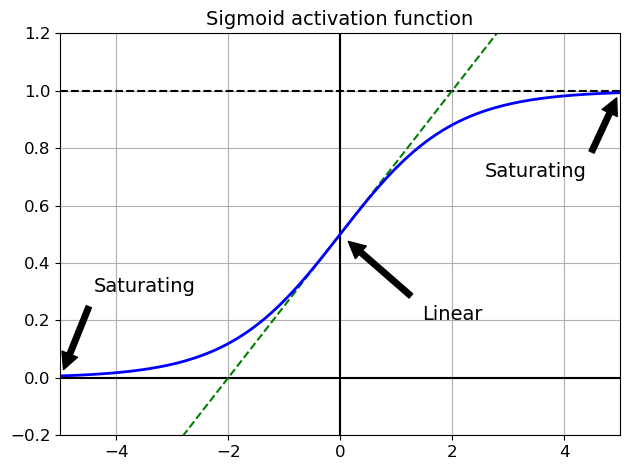

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Glorot и He инициализация

В своей работе Glorot и Bengio предлагают способ значительно облегчить проблему нестабильных градиентов. Они указывают на то, что нам нужно, чтобы сигнал работал правильно в обоих направлениях: в прямом направлении при прогнозировании и в обратном направлении при обратном распространении градиентов. Мы не хотим, чтобы сигнал угас, и при этом мы не хотим, чтобы он взрывался и насыщался. Для получения требуемого уровня сигнала, авторы утверждают, что нам нужно чтобы дисперсия выходов каждого слоя должна быть равной дисперсии его входов, и нам нужно градиент, которые имеют равные дисперсии до и после прохождения через слой в обратном направлении. Это на самом деле не представляется возможным, чтобы это гарантировать так как если слой не имеет равное количество входов и нейронов, но Glorot и Bengio предложили хороший компромисс, который доказал свою работу очень хорошо на практике: веса соединений каждого слоя должны быть инициализированы случайным образом, как описано в уравнении 11-1 , где $fan_{avg} =
(fan_{in} + fan_{out})/2$. Эта стратегия инициализации называется инициализацией Ксавье или инициализация Glorot, после первого автора статьи.

**Equation 11-1: Xavier initialization (when using the logistic activation function)**

$
\begin{split}
& \text{Normal distribution with mean 0 and standard deviation }
\sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}}\\
& \text{Or a uniform distribution between -r and +r, with }
r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}}
\end{split}
$

Если вы замените $fan_{avg}$ на $fan_{in}$ в уравнении 11-1, вы получите стратегию инициализации, предложенную Yann LeCun в 1990-х годах. Он назвал это инициализацией LeCun . Женевьева Орр и Клаус-Роберт Мюллер даже рекомендовали это в своей книге «Нейронные сети: хитрости торговли» (Springer) 1998 года. Инициализация LeCun эквивалентна инициализации Glorot, когда $fan_{in} = fan_{out}$. Исследователям потребовалось более десяти лет, чтобы понять, насколько важен этот трюк. Использование инициализации Glorot может значительно ускорить обучение, и это один из приемов, которые привели к успеху глубокого обучения.
В некоторых статьях представлены аналогичные стратегии для разных функций активации. Эти стратегии отличаются только масштабом дисперсии и используют ли они $fan_{avg}$ на $fan_{in}$, как показано в таблице 11-1  (для равномерного распределения, просто вычислить $r = \sqrt{3 \sigma^2}$. Стратегия инициализации для функции активации ReLU (и ее варианты, включая активацию ELU, описанную ниже) иногда называется инициализацией He в честь имени первого автора статьи. Функция активации SELU будет объяснена позже. Она может быть использована с инициализацией LeCun (желательно с нормальным распределением, как мы увидим).

**Table 11-1: Initialization parameters for each type of activation function**

* Logistic uniform: $ r = \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Logistic normal: $ \sigma = \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent uniform: $ r = 4 \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* Hyperbolic tangent normal: $ \sigma = 4 \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) uniform: $ r = \sqrt{2} \sqrt{\dfrac{6}{n_\text{inputs} + n_\text{outputs}}} $
* ReLU (and its variants) normal: $ \sigma = \sqrt{2} \sqrt{\dfrac{2}{n_\text{inputs} + n_\text{outputs}}} $

<img src = "tab11_1.jpg">

По умолчанию Keras использует инициализацию Glorot с равномерным распределением. При создании слоя вы можете изменить это на инициализацию He, установив ```python kernel_initializer = "he_uniform"``` или ```python kernel_initializer = "he_normal"``` следующим образом:
```python keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal") ```
Если вы хотите его инициализацию с равномерным распределением, но на основе $fan_{avg}$ , а $fan_{in}$ в , вы можете использовать ```python VarianceScaling``` инициализатора, например так:


```python
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                 distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)```

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Ненасыщенные функции активации

Одним из выводов, сделанных Глоротом и Бенжио в статье 2010 года, было то, что проблемы с нестабильными градиентами частично были связаны с плохим выбором функции активации. До тех пор большинство людей полагали, что, если Мать-Природа решила использовать функции активации сигмовидной железы в биологических нейронах, то сигмоида должна быть отличным выбором. Но оказывается, что другие функции активации ведут себя намного лучше в глубоких нейронных сетях - в частности, функция активации ReLU, главным образом потому, что она не насыщает положительные значения (и потому, что она быстро вычисляется).
К сожалению, функция активации ReLU не идеальна. Он страдает от проблемы, известной как умирающие ReLU : во время обучения некоторые нейроны эффективно «умирают», что означает, что они перестают выводить что-либо кроме 0. В некоторых случаях вы можете обнаружить, что половина нейронов вашей сети мертва, особенно если вы использовали большая скорость обучения. Нейрон умирает, когда его веса изменяются таким образом, что взвешенная сумма его входов является отрицательной для всех экземпляров в обучающем наборе. Когда это происходит, он просто продолжает выводить нули, и Gradient Descent больше не влияет на него, потому что градиент функции ReLU равен нулю, когда ее вход отрицателен.
Чтобы решить эту проблему, вы можете использовать вариант функции LeakyReLU, такой как ReLU с утечкой . Эта функция определяется как LeakyReLU $α( z ) = max(αz , z)$ (см. Рис. 11-2  ). Гиперпараметр α определяет, насколько «утечка» функции: это угол наклона функции для z <0 и обычно устанавливается на 0,01. Этот небольшой уклон гарантирует, что протекающие ReLU никогда не погибнут; они могут впасть в длительную кому, но у них есть шанс в конце концов проснуться. В 2015 году сравнивалось несколько вариантов функции активации ReLU, и один из ее выводов заключался в том, что неплотные варианты всегда превосходили строгую функцию активации ReLU. Фактически, установка α = 0,2 (огромная утечка), казалось, привела к лучшей производительности, чем α = 0,01 (небольшая утечка). В документе также оценивалась рандомизированная утечка ReLU (RReLU), где α выбирается случайным образом в заданном диапазоне во время обучения и фиксируется на среднем значении во время тестирования. RReLU также работал довольно хорошо и, похоже, выступал в качестве регуляризатора (снижая риск переобучения). Наконец, в статье оценивается параметрическая утечка ReLU (PReLU), где α разрешается изучать во время обучения (вместо того, чтобы быть гиперпараметром, он становится параметром, который может быть изменен путем обратного распространения, как любой другой параметр). Сообщалось, что PReLU сильно превосходит ReLU в наборах данных с большими изображениями, но для небольших наборов данных он рискует переобучить тренировочный набор.

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


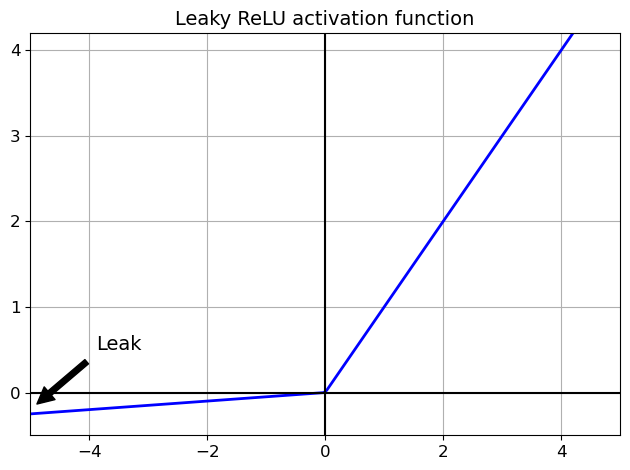

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [23]:
tf.random.set_seed(42)
np.random.seed(42)
alpha = 0.02
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="lecun_normal"),
    keras.layers.LeakyReLU(alpha = alpha),
    keras.layers.Dense(100, kernel_initializer="lecun_normal"),
    keras.layers.LeakyReLU(alpha = alpha),
    keras.layers.Dense(10, activation="softmax")
])

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [25]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7422 - accuracy: 0.7584 - val_loss: 0.5340 - val_accuracy: 0.8190
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4939 - accuracy: 0.8267 - val_loss: 0.4425 - val_accuracy: 0.8468
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4494 - accuracy: 0.8409 - val_loss: 0.5517 - val_accuracy: 0.7944
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4237 - accuracy: 0.8525 - val_loss: 0.4040 - val_accuracy: 0.8610
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4055 - accuracy: 0.8578 - val_loss: 0.3838 - val_accuracy: 0.8658
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3881 - accuracy: 0.8637 - val_loss: 0.3811 - val_accuracy: 0.8690
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3763 - accuracy: 0.8673 - val_loss: 0.3725 - val_accuracy:

Посмотрим как влияет на качество обучения RPLU

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None),
    keras.layers.Dense(10, activation="softmax")
])

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [29]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6930 - accuracy: 0.7709 - val_loss: 0.5145 - val_accuracy: 0.8282
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4796 - accuracy: 0.8329 - val_loss: 0.4319 - val_accuracy: 0.8550
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4349 - accuracy: 0.8467 - val_loss: 0.5297 - val_accuracy: 0.8068
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4082 - accuracy: 0.8567 - val_loss: 0.3898 - val_accuracy: 0.8666
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3896 - accuracy: 0.8629 - val_loss: 0.3783 - val_accuracy: 0.8696
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3714 - accuracy: 0.8683 - val_loss: 0.3701 - val_accuracy: 0.8738
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3600 - accuracy: 0.8727 - val_loss: 0.3636 - val_accuracy:

И последнее, но не менее важное: статья Djork-Arné Clevert et al. предложил новую функцию активации, названную экспоненциальной линейной единицей (ELU), которая превзошла все варианты ReLU в экспериментах авторов: время обучения было сокращено, и нейронная сеть работала лучше на тестовом наборе. На рисунке 11-3  представлена функция графика, а в уравнении 11-2 показано ее определение.

**Equation 11-2: ELU activation function**

$
\operatorname{ELU}_\alpha(z) =
\begin{cases}
\alpha(\exp(z) - 1) & \text{if } z < 0\\
z & if z \ge 0
\end{cases}
$

Функция активации ELU очень похожа на функцию ReLU, с некоторыми существенными отличиями:
*	Он принимает отрицательные значения, когда z <0, что позволяет устройству иметь средний выходной сигнал ближе к 0 и помогает решить проблему исчезающих градиентов. Гиперпараметр α определяет значение, к которому приближается функция ELU, когда z является большим отрицательным числом. Обычно он равен 1, но вы можете настроить его, как любой другой гиперпараметр.
*	Он имеет ненулевой градиент для z <0, что позволяет избежать проблемы мертвых нейронов.
*	Если α равно 1, то функция является гладкой везде, в том числе около z = 0, что помогает ускорить градиентный спуск, поскольку она не сильно отскакивает влево и вправо от z = 0.
Основным недостатком функции активации ELU является то, что она медленнее вычисляется, чем функция ReLU и ее варианты (из-за использования экспоненциальной функции). Более высокая скорость сходимости во время обучения компенсирует это медленное вычисление, но, тем не менее, во время тестирования сеть ELU будет работать медленнее, чем сеть ReLU.


### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


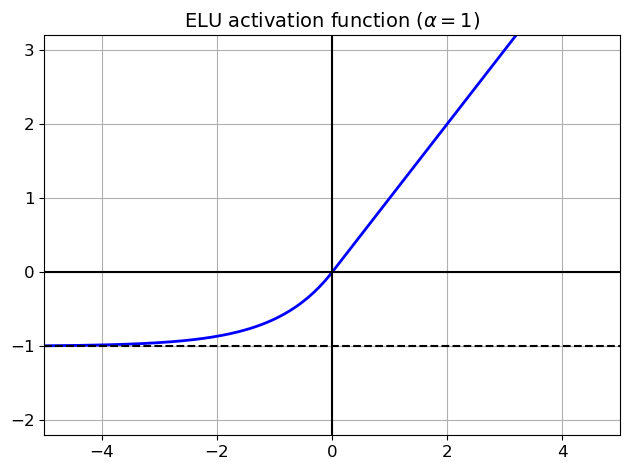

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

Затем в 2017[great paper](https://arxiv.org/pdf/1706.02515.pdf) Гюнтер Кламбауэр и соавт. представил функцию активации Scaled ELU (SELU): как следует из названия, это масштабированный вариант функции активации ELU. Авторы показали, что если вы строите нейронную сеть, состоящую исключительно из стека плотных слоев, и если все скрытые слои используют функцию активации SELU, то сеть будет самостоятельно нормализоваться: выходные данные каждого слоя будут иметь тенденцию сохранять среднее значение 0 и стандартное отклонение 1 во время тренировки, что решает проблему исчезающих / взрывных градиентов. В результате функция активации SELU часто значительно превосходит другие функции активации для таких нейронных сетей (особенно глубоких). Однако есть несколько условий для самонормализации (математическое обоснование см. В статье):
•	Входные характеристики должны быть стандартизированы (среднее значение 0 и стандартное отклонение 1).
•	Вес каждого скрытого слоя должен быть инициализирован с помощью обычной инициализации LeCun. В Keras это означает установку kernel_initializer = "lecun_normal" .
•	Архитектура сети должна быть последовательной. К сожалению, если вы попытаетесь использовать SELU в непоследовательных архитектурах, таких как рекуррентные сети или сети с пропущенными соединениями (т. Е. Соединения, которые пропускают слои, например, в сетях Wide & Deep), самонормализация не гарантируется Таким образом, SELU не обязательно будет превосходить другие функции активации.
•	В статье гарантируется самонормализация только в том случае, если все слои плотные, но некоторые исследователи отмечают, что функция активации SELU может улучшить производительность и в сверточных нейронных сетях 

### SELU

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


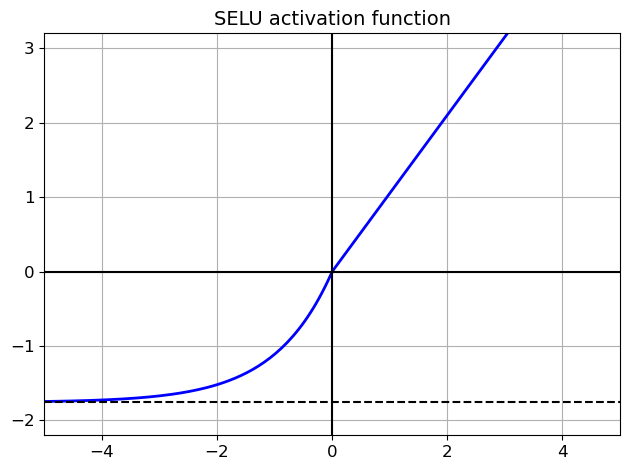

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [3]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [6]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [7]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 38s 19ms/step - loss: 2.0725 - accuracy: 0.1800 - val_loss: 1.9937 - val_accuracy: 0.1744
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: nan - accuracy: 0.1521 - val_loss: nan - val_accuracy: 0.0914
Epoch 3/5
1719/1719 [==============================] - 32s 19ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 5/5
1719/1719 [==============================] - 33s 19ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 19s 8ms/step - loss: 1.7183 - accuracy: 0.2600 - val_loss: 1.4668 - val_accuracy: 0.4008
Epoch 2/5
1719/1719 [==============================] - 13s 8ms/step - loss: 2.1356 - accuracy: 0.1545 - val_loss: 1.8413 - val_accuracy: 0.1996
Epoch 3/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.8328 - accuracy: 0.2362 - val_loss: 1.3505 - val_accuracy: 0.3760
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.5698 - accuracy: 0.3375 - val_loss: 1.3402 - val_accuracy: 0.4504
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.5496 - accuracy: 0.3429 - val_loss: 1.3213 - val_accuracy: 0.4270


Итак, какую функцию активации вы должны использовать для скрытых слоев ваших глубоких нейронных сетей? Хотя ваш разброс будет варьироваться, в общем SELU> ELU> неплотный ReLU (и его варианты)> ReLU> tanh> logistic. Если архитектура сети предотвращает ее самонормализацию, то ELU может работать лучше, чем SELU (поскольку SELU не является плавным при z = 0). Если вас сильно волнует задержка во время выполнения, вы можете предпочесть негерметичный ReLU. Если вы не хотите настраивать еще один гиперпараметр, вы можете использовать значения α по умолчанию, используемые Keras (например, 0,3 для неплотного ReLU). Если у вас есть свободное время и вычислительные мощности, вы можете использовать перекрестную проверку для оценки других функций активации, таких как RReLU, если ваша сеть перегружена, или PReLU, если у вас огромный тренировочный набор. Тем не менее, поскольку ReLU является наиболее часто используемой функцией активации (на данный момент), многие библиотеки и аппаратные ускорители обеспечивают специфичные для ReLU оптимизации; поэтому, если скорость является вашим приоритетом, ReLU все еще может быть лучшим выбором.  

# Пакетная нормализация

Хотя использование инициализации He вместе с ELU (или любым вариантом ReLU) может значительно снизить опасность проблем исчезающего/взрывного градиента в начале обучения, это не гарантирует, что они не вернутся во время обучения.
В 2015 Сергей Иоффе и Кристиан Сегеди предложили метод, называемый нормализацией партии (BN), который решает эти проблемы. Техника состоит в добавлении операции в модель непосредственно перед или после функции активации каждого скрытого слоя. Эта операция просто центрирует и нормализует каждый вход, затем масштабирует и сдвигает результат, используя два новых вектора параметров на слой: один для масштабирования, другой для сдвига. Другими словами, операция позволяет модели узнать оптимальный масштаб и среднее значение каждого из входов слоя. Во многих случаях, если вы добавляете слой BN в качестве самого первого слоя вашей нейронной сети, вам не нужно стандартизировать свой тренировочный набор (например, используя StandardScaler ); слой BN сделает это за вас (ну, примерно, так как он просматривает только один пакет за раз, и он также может масштабировать и сдвигать каждую входную функцию).
Для того, чтобы центрировать и нормализовать входы, алгоритм должен оценить среднее значение и стандартное отклонение каждого входа. Это достигается путем оценки среднего и стандартного отклонения входного сигнала по текущей мини-партии (отсюда и название «нормализация партии»). Вся операция суммируется шаг за шагом в уравнении 11-3 .

**Equation 11-3: Batch Normalization algorithm**

$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\mathbf{x}^{(i)}}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2}\\
3.\quad & \hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}}\\
4.\quad & \mathbf{z}^{(i)} = \gamma \otimes \hat{\mathbf{x}}^{(i)} + \beta
\end{split}
$

В этом алгоритме:
*	${\mu}_B$ - вектор средних значений ввода, оцениваемый по всей мини-партии B (он содержит одно среднее значение для каждого входа).
*	${\sigma}_B$ - вектор стандартных отклонений на входе, также оцениваемый по всей мини-партии (он содержит одно стандартное отклонение на вход).
*	$m_B$ - количество экземпляров в мини-партии.
*	$\hat{\mathbf{x}}^{(i)}$ - вектор нулевых центрированных и нормализованных входных данных, например, i .
*	$\gamma$ - вектор выходного параметра масштаба для слоя (он содержит один параметр масштаба на вход).
*	$\otimes$ представляет поэлементное умножение (каждый вход умножается на соответствующий выходной масштабный параметр).
*	$\beta$ - вектор параметров выходного смещения (смещения) для слоя (он содержит один параметр смещения на вход). Каждый вход смещен соответствующим параметром сдвига.
*	$\epsilon$ - крошечное число, которое избегает деления на ноль (обычно $10^{–5}$ ). Это называется сглаживающим термином.
*	${z}^{(i)}$ - результат операции BN. Это измененная и измененная версия входных данных.


Таким образом, во время обучения BN стандартизирует свои входные данные, затем масштабирует и компенсирует их. Хорошо! Как насчет во время теста? Ну, это не так просто. Действительно, нам может потребоваться делать прогнозы для отдельных экземпляров, а не для пакетов экземпляров: в этом случае у нас не будет возможности вычислить среднее значение и стандартное отклонение для каждого входа. Более того, даже если у нас есть пакет экземпляров, он может быть слишком маленьким или экземпляры могут быть независимыми и одинаково распределенными, поэтому вычисление статистики по экземплярам пакета будет ненадежным. Одним из решений может быть ожидание до конца обучения, а затем выполнение всего обучающего набора через нейронную сеть и вычисление среднего и стандартного отклонения каждого входа уровня BN. Эти «окончательные» средства ввода и стандартные отклонения могут затем использоваться вместо средств пакетного ввода и стандартных отклонений при прогнозировании. Тем не менее, большинство реализаций Пакетной нормализации оценивают эти окончательные статистические данные во время обучения, используя скользящую среднюю из средств ввода слоя и стандартные отклонения. Это то, что делает Keras автоматически, когда вы используете слой BatchNormalization . Подводя итог, можно узнать четыре вектора параметров в каждом нормированном на пакет уровне: γ (вектор выходного масштаба) и β (вектор выходного смещения) изучаются посредством регулярного обратного распространения, а μ (конечный вектор среднего входного значения) и σ ( конечный входной вектор стандартного отклонения) оценивается с использованием экспоненциальной скользящей средней. Обратите внимание, что μ и σ оцениваются во время обучения, но они используются только после обучения (для замены средств пакетного ввода и стандартных отклонений в уравнении 11-3 ).
Иоффе и Сегеди продемонстрировали, что пакетная нормализация значительно улучшила все глубокие нейронные сети, с которыми они экспериментировали, что привело к значительному улучшению задачи классификации ImageNet (ImageNet - это большая база данных изображений, классифицированных по многим классам, которые обычно используются для оценки систем компьютерного зрения). Проблема исчезающих градиентов была сильно уменьшена до такой степени, что они могли использовать насыщающие функции активации, такие как танх и даже логистическую функцию активации. Сети были также намного менее чувствительны к инициализации веса. Авторы смогли использовать гораздо более высокие темпы обучения, значительно ускоряя процесс обучения. В частности, они отмечают, что:
Применительно к современной модели классификации изображений нормализация партии достигает той же точности с 14-кратным сокращением шагов обучения и значительно превосходит исходную модель. […] Используя ансамбль нормализованных по партиям сетей, мы улучшаем лучший опубликованный результат по классификации ImageNet: достигаем 4,9% ошибок проверки топ-5 (и 4,8% ошибок тестирования), превышая точность оценок людей.
Наконец, как подарок, который продолжает дарить, нормализация партии действует как регуляризатор, уменьшая потребность в других методах регуляризации (таких как выпадение, описанное ниже в этой главе).
Пакетная нормализация, однако, добавляет некоторую сложность модели (хотя она может устранить необходимость нормализации входных данных, как мы обсуждали ранее). Кроме того, существует штраф за время выполнения: нейронная сеть делает более медленные прогнозы из-за дополнительных вычислений, требуемых на каждом уровне. К счастью, после тренировки часто можно объединить слой BN с предыдущим, что позволяет избежать штрафа за время выполнения. Это делается путем обновления весов и смещений предыдущего уровня, чтобы он напрямую генерировал выходные данные соответствующего масштаба и смещения. 

Как и в большинстве случаев с Keras, реализация нормализации партии проста и интуитивно понятна. Просто добавьте слой BatchNormalization до или после функции активации каждого скрытого слоя и при необходимости добавьте слой BN, а также первый слой в вашей модели. Например, эта модель применяет BN после каждого скрытого слоя и в качестве первого слоя в модели (после выравнивания входных изображений):

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

Как видите, каждый уровень BN добавляет четыре параметра на вход: γ , β , µ и σ (например, первый уровень BN добавляет 3136 параметров, что составляет 4 × 784). Последние два параметра, μ и σ , являются скользящими средними; обратное распространение не влияет на них, поэтому Keras называет их «необучаемыми» 9 (если вы посчитаете общее количество параметров BN, 3136 + 1200 + 400 и разделите на 2, вы получите 2 368, то есть общее число -тренируемые параметры в этой модели).
Давайте посмотрим на параметры первого слоя BN. Два обучаемых (путем обратного распространения), а два нет:


Теперь, когда вы создаете слой BN в Keras, он также создает две операции, которые будут вызываться Keras на каждой итерации во время обучения. Эти операции обновят скользящие средние. Поскольку мы используем бэкэнд TensorFlow, эти операции являются операциями TensorFlow:

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
bn1.updates

C:\Users\Sidromnik\AppData\Local\Temp\ipykernel_34664\2538512196.py:1: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  bn1.updates


[]

Авторы статьи BN высказались за добавление слоев BN перед функциями активации, а не после (как мы только что сделали). Существует некоторая дискуссия по этому поводу, которая, кажется, является предпочтительной, зависит от задачи - вы также можете поэкспериментировать с этим, чтобы увидеть, какой вариант лучше всего работает с вашим набором данных. Чтобы добавить слои BN перед функциями активации, необходимо удалить функцию активации из скрытых слоев и добавить их как отдельные слои после слоев BN. Более того, поскольку слой нормализации партии включает в себя один параметр смещения на вход, вы можете удалить член смещения из предыдущего слоя (просто передайте use_bias = False при его создании):

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5364 - accuracy: 0.8146 - val_loss: 0.3731 - val_accuracy: 0.8726
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3927 - accuracy: 0.8601 - val_loss: 0.3461 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3577 - accuracy: 0.8713 - val_loss: 0.3406 - val_accuracy: 0.8786
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3288 - accuracy: 0.8812 - val_loss: 0.3211 - val_accuracy: 0.8844
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3080 - accuracy: 0.8893 - val_loss: 0.3071 - val_accuracy: 0.8916
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2922 - accuracy: 0.8944 - val_loss: 0.3104 - val_accuracy: 0.8886
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2808 - accuracy: 0.8987 - val_loss: 0.3092 - val_accuracy:

Класс `BatchNormalization` имеет несколько гиперпараметров, которые можно настроить. Значения по умолчанию, как правило, будут хорошими, но иногда вам может понадобиться настроить импульс. Этот гиперпараметр используется слоем `BatchNormalization` при обновлении экспоненциальных скользящих средних; задается новое значение $\hat V$ (т.е., новый вектор входных параметров или стандартных отклонений, вычисленных по текущей партии), слой обновляет скользящий средний $\hat V$
используя следующее уравнение:
$$\hat V ← \hat V × momentum + V × (1 − momentum)$$
Хорошее значение импульса обычно близко к 1; например, 0,9, 0,99 или 0,999 (вам нужно больше 9 с для больших наборов данных и меньших мини-пакетов).
Другим важным гиперпараметром является ось : она определяет, какую ось следует нормализовать. По умолчанию он равен –1, что означает, что по умолчанию он нормализует последнюю ось (используя средние значения и стандартные отклонения, рассчитанные по другим осям). Когда входной пакет является 2D (т. е. Форма пакета [batch size, features]), это означает, что каждый входной объект будет нормализован на основе среднего значения и стандартного отклонения, рассчитанного для всех экземпляров в пакете. Например, первый уровень BN в предыдущем примере кода будет независимо нормализовать (и масштабировать и сдвигать) каждую из 784 входных параметров. Если мы переместим первый слой BN перед слоем Flatten, то входные пакеты будут 3D, с формой [batch size, height, width]; следовательно, слой BN будет вычислять 28 средних значений и 28 стандартных отклонений (1 на столбец пикселей, рассчитанный для всех экземпляров в пакете и для всех строк в столбце), и он будет нормализовать все пиксели в данном столбце с использованием того же среднего значения и стандартное отклонение. Также будет только 28 масштабных параметров и 28 параметров сдвига. Если вместо этого вы все еще хотите обрабатывать каждый из 784 пикселей независимо, то вам следует установить axis = [1, 2].
Обратите внимание, что уровень BN не выполняет одинаковые вычисления во время тренировки и после тренировки: он использует статистику партии во время тренировки и «окончательную» статистику после тренировки (т. е. конечные значения скользящих средних). Давайте посмотрим на исходный код этого класса, чтобы увидеть, как это обрабатывается:
```python
class BatchNormalization(keras.layers.Layer):
    [...]
    def call(self, inputs, training=None):
        [...]
```
Метод `call()` - он непосредственно выполняет вычисления; как видите, он имеет дополнительный обучающий аргумент, который по умолчанию имеет значение None , но метод `fit()` устанавливает его равным 1 во время обучения. Если вам когда-нибудь понадобится написать пользовательский слой, и он должен вести себя по-разному во время обучения и тестирования, добавьте обучающий аргумент в метод `call()` и используйте этот аргумент в методе, чтобы решить, что вычислять 10.
Пакетная нормализация стала одним из наиболее часто используемых слоев в глубоких нейронных сетях, так что на диаграммах она часто опускается, так как предполагается, что BN добавляется после каждого слоя. Но недавняя статья Хонги Чжан и соавт. может изменить это предположение: используя новую методику инициализации веса с фиксированным обновлением (fixup), авторам удалось обучить очень глубокую нейронную сеть (10 000 слоев!) без BN, достигая современного уровня производительности при сложной классификации изображений задачи. Однако, так как это новейшее исследование, вы можете подождать дополнительных исследований, чтобы подтвердить этот вывод, прежде чем отказаться от нормализации партии.

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5328 - accuracy: 0.8125 - val_loss: 0.3690 - val_accuracy: 0.8704
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3926 - accuracy: 0.8597 - val_loss: 0.3395 - val_accuracy: 0.8802
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3579 - accuracy: 0.8708 - val_loss: 0.3416 - val_accuracy: 0.8760
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3278 - accuracy: 0.8817 - val_loss: 0.3166 - val_accuracy: 0.8844
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3086 - accuracy: 0.8880 - val_loss: 0.3073 - val_accuracy: 0.8894
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2933 - accuracy: 0.8931 - val_loss: 0.3107 - val_accuracy: 0.8886
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2788 - accuracy: 0.8977 - val_loss: 0.3107 - val_accuracy:

## Градиент отсечения

Другой популярный метод для смягчения проблемы взрывающихся градиентов состоит в том, чтобы обрезать градиенты во время обратного распространения, чтобы они никогда не превышали некоторый порог. Это называется Gradient Clipping. Этот метод чаще всего используется в рекуррентных нейронных сетях, так как пакетная нормализация сложно использовать в RNN, как мы увидим позже. Для других типов сетей обычно достаточно BN.
В Keras реализация Gradient Clipping - это просто вопрос установки аргумента clipvalue или clipnorm при создании оптимизатора, например:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

Этот оптимизатор будет обрезать каждый компонент вектора градиента до значения от –1,0 до 1,0. Это означает, что все частные производные потери (в отношении каждого обучаемого параметра) будут ограничены между –1,0 и 1,0. Порог - это гиперпараметр, который вы можете настроить. Обратите внимание, что это может изменить ориентацию вектора градиента. Например, если исходный вектор градиента равен [0,9, 100,0], он в основном указывает в направлении второй оси; но как только вы обрезаете его по значению, вы получите [0,9, 1,0], который примерно указывает на диагональ между двумя осями. На практике этот подход работает хорошо. Если вы хотите убедиться, что Gradient Clipping не меняет направление вектора градиента, вы должны обрезать по норме, установив clipnorm вместо clipvalue. Это будет обрезать весь градиент, если его ℓ 2 нормы больше порога вы выбрали. Например, если вы установите clipnorm = 1.0 , то вектор [0.9, 100.0] будет обрезан до [0.00899964, 0.9999595], сохраняя его ориентацию, но почти исключая первый компонент. Если вы заметили, что градиенты сильно возрастают во время обучения (вы можете отслеживать размер градиентов с помощью TensorBoard), вы можете попробовать как урезать по значению, так и урезать по норме, с различными пороговыми значениями, и посмотрите, какая опция лучше всего работает на наборе при проверки.

## Повторное использование предварительно обученных слоев

Как правило, не очень хорошая идея тренировать очень большое DNN с нуля: вместо этого вы всегда должны пытаться найти существующую нейронную сеть, которая выполняет задачу, аналогичную той, которую вы пытаетесь решить, затем повторно используйте нижние уровни этой сети. Эта техника называется трансферным обучением. Это не только значительно ускорит обучение, но и потребует значительно меньшего количества тренировочных данных.
Предположим, у вас есть доступ к DNN, который был обучен для классификации изображений на 100 различных категорий, включая животных, растения, транспортные средства и предметы быта. Теперь вы хотите обучить DNN для классификации определенных типов транспортных средств. Эти задачи очень похожи, даже частично перекрываются, поэтому вы должны попытаться повторно использовать части первой сети (см. Рис. 11-4).

<img src = "transfer.jpg">

Если входные изображения вашей новой задачи не имеют такой же размер, как те, что использовались в исходной задаче, вам обычно нужно добавить шаг предварительной обработки, чтобы изменить их размер до размера, ожидаемого исходной моделью. В более общем смысле, трансферное обучение будет работать лучше всего, когда входы имеют схожие низкоуровневые функции.
Выходной слой исходной модели обычно следует заменять, поскольку он, скорее всего, вообще не полезен для новой задачи и может даже не иметь нужного количества выходов для новой задачи.
Точно так же верхние скрытые слои исходной модели с меньшей вероятностью будут столь же полезны, как и нижние слои, поскольку высокоуровневые функции, наиболее полезные для новой задачи, могут значительно отличаться от тех, которые были наиболее полезны для исходной задачи. , Вы хотите найти правильное количество слоев для повторного использования.
Примечание
Чем больше похожих задач, тем больше слоев вы хотите использовать повторно (начиная с нижних уровней). Для очень похожих задач попробуйте сохранить все скрытые слои и просто заменить выходной слой.
Попробуйте сначала заморозить все повторно используемые слои (т. е. Сделать их веса необучаемыми, чтобы градиентный спуск не изменил их), затем обучите свою модель и посмотрите, как она работает. Затем попробуйте разморозить один или два верхних скрытых слоя, чтобы позволить обратному распространению настроить их, и посмотреть, улучшится ли производительность. Чем больше у вас тренировочных данных, тем больше слоев вы сможете разморозить. Также полезно уменьшить скорость обучения, когда вы размораживаете повторно используемые слои: это позволит избежать разрушения их точно настроенных весов.
Если вы все еще не можете добиться хорошей производительности, и у вас мало тренировочных данных, попробуйте сбросить верхний скрытый слой (слои) и снова заморозить все оставшиеся скрытые слои. Вы можете перебирать, пока не найдете нужное количество слоев для повторного использования. Если у вас много тренировочных данных, вы можете попробовать заменить верхние скрытые слои вместо того, чтобы отбрасывать их, и даже добавить больше скрытых слоев.

### Transfer learning with Keras

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

Давайте посмотрим на пример. Предположим, что набор данных Fashion MNIST содержит только восемь классов - например, все классы, кроме сандалии и рубашки. Кто-то построил и обучил модель Keras на этом наборе и получил достаточно хорошую производительность (точность> 90%). Давайте назовем эту модель А. Теперь вы хотите решить другую задачу: у вас есть изображения сандалий и рубашек, и вы хотите обучить двоичный классификатор (положительный = рубашка, отрицательный = сандалия). Ваш набор данных довольно маленький; у вас есть только 200 помеченных изображений. Когда вы готовите новую модель для этой задачи (назовем ее моделью B) с той же архитектурой, что и модель A, она работает достаточно хорошо (точность 97,2%). Но так как это намного более легкая задача (есть только два класса), вы надеялись на большее. Выпивая утренний кофе, вы понимаете, что ваша задача очень похожа на задачу А, поэтому, возможно, вам поможет трансферное обучение? Давайте разберемся!
Сначала вам нужно загрузить модель A и создать новую модель на основе слоев этой модели. Давайте повторно используем все слои, кроме выходного:

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3542 - accuracy: 0.8745 - val_loss: 0.3080 - val_accuracy: 0.8889
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2666 - accuracy: 0.9074 - val_loss: 0.2685 - val_accuracy: 0.9038
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2447 - accuracy: 0.9124 - val_loss: 0.2404 - val_accuracy: 0.9153
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2290 - accuracy: 0.9196 - val_loss: 0.2478 - val_accuracy: 0.9160
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2161 - accuracy: 0.9236 - val_loss: 0.2295 - val_accuracy: 0.9213
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2071 - accuracy: 0.9252 - val_loss: 0.2199 - val_accuracy: 0.9180
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.1987 - accuracy: 0.9300 - val_loss: 0.2286 - val_accuracy:

In [55]:
model_A.save("my_model_A.h5")

C:\Users\Sidromnik\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 34ms/step - loss: 0.5158 - accuracy: 0.7850 - val_loss: 0.1479 - val_accuracy: 0.9797
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.0993 - accuracy: 0.9900 - val_loss: 0.1052 - val_accuracy: 0.9817
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0641 - accuracy: 0.9950 - val_loss: 0.0843 - val_accuracy: 0.9848
Epoch 4/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0488 - accuracy: 0.9950 - val_loss: 0.0736 - val_accuracy: 0.9828
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0371 - accuracy: 0.9950 - val_loss: 0.0651 - val_accuracy: 0.9838
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0304 - accuracy: 0.9950 - val_loss: 0.0620 - val_accuracy: 0.9848
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 0.0650 - val_accuracy: 0.9817
Epoch 8/20
7/7 [===========

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 784)               3136      
 chNormalization)                                                
                                                                 
 dense_215 (Dense)           (None, 300)               235200    
                                                                 
 batch_normalization_4 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_216 (Dense)           (None, 100)              

In [60]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Обратите внимание, что model_A и model_B_on_A теперь совместно используют несколько слоев. Когда вы тренируете model_B_on_A , это также повлияет на model_A . Если вы хотите избежать этого, вам нужно клонировать model_A, прежде чем повторно использовать его слои. Для этого вы клонируете архитектуру модели A с помощью clone_model () , а затем копируете ее веса (поскольку clone_model () не клонирует веса): 

In [61]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Теперь вы можете обучить model_B_on_A для задачи B, но поскольку новый выходной слой был инициализирован случайным образом, он будет делать большие ошибки (по крайней мере, в течение первых нескольких эпох), поэтому будут большие градиенты ошибок, которые могут разрушить повторно используемые веса. Чтобы избежать этого, один из подходов состоит в том, чтобы заморозить повторно используемые слои в течение первых нескольких эпох, давая новому слою некоторое время для изучения разумных весов. Для этого установите обучаемый атрибут каждого слоя в False и скомпилируйте модель:

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

Вы должны всегда компилировать свою модель после замораживания или размораживания слоев.
Теперь вы можете обучить модель в течение нескольких эпох, затем разморозить повторно используемые слои (что требует повторной компиляции модели) и продолжить обучение для точной настройки повторно используемых слоев для задачи B. После размораживания повторно используемых слоев обычно это хорошая идея. чтобы уменьшить скорость обучения, еще раз, чтобы не повредить повторно используемые веса:


In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 31ms/step - loss: 0.7770 - accuracy: 0.7000 - val_loss: 0.5532 - val_accuracy: 0.7292
Epoch 2/4
7/7 [==============================] - 0s 11ms/step - loss: 0.4008 - accuracy: 0.7900 - val_loss: 0.3370 - val_accuracy: 0.8154
Epoch 3/4
7/7 [==============================] - 0s 11ms/step - loss: 0.2476 - accuracy: 0.8850 - val_loss: 0.2263 - val_accuracy: 0.8986
Epoch 4/4
7/7 [==============================] - 0s 11ms/step - loss: 0.1696 - accuracy: 0.9250 - val_loss: 0.1606 - val_accuracy: 0.9493


Epoch 1/16
7/7 [==============================] - 1s 31ms/step - loss: 0.0831 - accuracy: 0.9850 - val_loss: 0.0583 - val_accuracy: 0.9848
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.0344 - accuracy: 0.9900 - val_loss: 0.0450 - val_accuracy: 0.9868
Epoch 3/16
7/7 [==============================] - 0s 12ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9899
Epoch 4/16
7/7 [==============================] - 0s 11ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0333 - val_accuracy: 0.9909
Epoch 5/16
7/7 [==============================] - 0s 12ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0307 - val_accuracy: 0.9909
Epoch 6/16
7/7 [==============================] - 0s 12ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0289 - val_accuracy: 0.9909
Epoch 7/16
7/7 [==============================] - 0s 12ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9929
Epoch 8/16
7/7 [===========

Итак, каков окончательный вердикт? Что ж, точность теста этой модели составляет 98.99%, что означает, что при обучении с помощью переноса частота ошибок снижается с 2,8% до почти 1.1%! Это в два раза!

In [64]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9930


[0.02596135437488556, 0.9929999709129333]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 0.9965


[0.01623493619263172, 0.9965000152587891]

In [66]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337

Вы убеждены? Не должно быть: я обманул! Я перепробовал много конфигураций, пока не нашел, что продемонстрировало сильное улучшение. Если вы попытаетесь изменить классы или случайное начальное число, вы увидите, что улучшение обычно падает, или даже исчезает или меняется на противоположное. То, что я сделал, называется «пытать данные до тех пор, пока они не признаются». Когда бумага выглядит слишком позитивно, вы должны быть подозрительны: возможно, эффектная новая техника на самом деле мало помогает (на самом деле, она может даже ухудшить производительность), но авторы перепробовали много вариантов и сообщили только о лучших результатах (что может быть связано с чистой удачей), не упоминая, сколько неудач они встретили на пути. В большинстве случаев это вовсе не вредно, но это одна из причин того, что многие результаты в науке никогда не могут быть воспроизведены.
Почему я обманул? Оказывается, что обучение передаче не очень хорошо работает с небольшими плотными сетями, возможно потому, что маленькие сети изучают мало шаблонов, а плотные сети изучают очень специфические шаблоны, которые вряд ли будут полезны в других задачах. Трансферное обучение лучше всего работает с глубокими сверточными нейронными сетями, которые, как правило, изучают детекторы функций, которые являются гораздо более общими (особенно на нижних уровнях). Мы вернемся к трансферному обучению позже, используя методы, которые мы только что обсудили.

## Необслуживаемая предварительная подготовка

Предположим, что вы хотите решить сложную задачу, для которой у вас не так много помеченных обучающих данных, но, к сожалению, вы не можете найти модель, обученную для аналогичной задачи. Не теряй надежду! Во-первых, вы должны попытаться собрать больше помеченных данных об обучении, но если вы не можете, вы все равно сможете выполнять неконтролируемую предварительную подготовку (см. Рисунок 11-5). Действительно, собирать немаркированные учебные примеры зачастую дешево, но дорого их маркировать. Если вы можете собрать большое количество немаркированных обучающих данных, вы можете попытаться использовать их для обучения неконтролируемой модели, такой как автоэнкодер или генеративная состязательная сеть. Затем вы можете повторно использовать нижние уровни автоэнкодера или нижние уровни дискриминатора GAN, добавить выходной слой для вашей задачи сверху и настроить конечную сеть, используя контролируемое обучение (т. е. с помеченными примерами обучения).
Именно эту технику Джеффри Хинтон и его команда использовали в 2006 году, что привело к возрождению нейронных сетей и успеху Deep Learning. До 2010 года неконтролируемая предварительная подготовка - как правило, с ограниченными машинами Больцмана - была нормой для глубоких сетей, и только после того, как была устранена проблема исчезающих градиентов, стало гораздо более распространенным обучение DNN исключительно с использованием контролируемого обучения. Необслуживаемая предварительная подготовка (сегодня, как правило, с использованием авто-кодеров или GAN, а не RBM) по-прежнему является хорошим вариантом, когда вам нужно решить сложную задачу, нет аналогичной модели, которую вы можете использовать повторно, и мало помеченных данных обучения, но много немаркированных данных обучения.
Обратите внимание, что в первые дни глубокого обучения было трудно обучать глубокие модели, поэтому люди использовали технику, называемую жадным послойным предварительным обучением (изображено на рисунке 11-5  ). Сначала они обучают неконтролируемую модель с одним слоем, обычно RBM, затем замораживают этот слой и добавляют еще один поверх него, затем обучают модель снова (фактически просто обучая новый слой), затем замораживают новый слой и добавьте еще один слой поверх него, снова обучите модель и так далее. В настоящее время все намного проще: люди обычно обучают полную неконтролируемую модель за один раз (т. е. На Рисунке 11-5  , просто начните прямо с третьего шага) и используют автоэнкодеры или GAN, а не RBM.

<img src ="transfer1.jpg">

###### Рисунок 11-5. При неконтролируемом обучении модель обучается на немаркированных данных (или на всех данных) с использованием неконтролируемой методики обучения, затем она настраивается для окончательного задания на маркированных данных с использованием методики контролируемого обучения; неконтролируемая часть может тренироваться по одному слою за раз, как показано здесь, или она может тренировать полную модель напрямую

## Предварительная подготовка по вспомогательному заданию

Если у вас мало обученных данных с метками, последний вариант - обучить первую нейронную сеть вспомогательной задаче, для которой вы можете легко получить или сгенерировать обучающие данные с маркировкой, а затем повторно использовать нижние уровни этой сети для вашей реальной задачи. Нижние уровни первой нейронной сети будут изучать детекторы функций, которые, вероятно, будут использоваться во второй нейронной сети.
Например, если вы хотите создать систему распознавания лиц, у вас может быть только несколько изображений каждого человека - явно недостаточно для обучения хорошего классификатора. Собирать сотни фотографий каждого человека было бы не практично. Тем не менее, вы могли бы собрать много изображений случайных людей в Интернете и обучить первую нейронную сеть, чтобы определить, изображают ли два разных изображения одного и того же человека. Такая сеть выучит хорошие детекторы функций для лиц, поэтому повторное использование ее нижних уровней позволит вам обучить хороший классификатор лиц, который использует мало обучающих данных.
Для приложений обработки естественного языка (NLP) вы можете загрузить корпус миллионов текстовых документов и автоматически генерировать из них помеченные данные. Например, вы можете случайным образом замаскировать некоторые слова и обучить модель, чтобы предсказать, что такое пропущенные слова (например, он должен предсказать, что пропущенное слово в предложении «Что вы говорите?», Вероятно, «есть» или «было») ). Если вы можете обучить модель для достижения высокой производительности при выполнении этой задачи, то она уже будет достаточно много знать о языке, и вы, безусловно, сможете повторно использовать ее для своей реальной задачи и точно настроить ее на свои маркированные данные.
Заметка
Самостоятельное обучение - это когда вы автоматически генерируете метки из самих данных, а затем тренируете модель в результирующем «помеченном» наборе данных, используя методы контролируемого обучения. Поскольку этот подход не требует никакой человеческой маркировки, его лучше всего классифицировать как форму обучения без учителя.

# Ускоренные оптимизаторы

Обучение очень большой глубокой нейронной сети может быть мучительно медленным. До сих пор мы видели четыре способа ускорить обучение (и найти лучшее решение): применение хорошей стратегии инициализации для весов соединений, использование хорошей функции активации, использование нормализации партии и повторное использование частей предварительно обученной сети (возможно, построенной на вспомогательное задание или использование обучения без учителя). Еще один огромный прирост скорости связан с использованием более быстрого оптимизатора, чем у обычного оптимизатора Gradient Descent. Далее мы представим самые популярные алгоритмы: оптимизацию импульса, ускоренный градиент Нестерова, AdaGrad, RMSProp и, наконец, оптимизацию Адама и Надама.

## Импульсный оптимизатор

Представьте себе шар для боулинга, катящийся по пологому склону по гладкой поверхности: он начнет медленно, но будет быстро набирать обороты, пока не достигнет конечной скорости (если есть некоторое трение или сопротивление воздуха). Это очень простая идея, лежащая в основе оптимизации импульса , proposed by Boris Polyak in 1964.13 В отличие от этого, регулярный градиентный спуск просто делает небольшие, регулярные шаги вниз по склону, поэтому алгоритму потребуется гораздо больше времени, чтобы достичь дна.
Оптимизация импульса во многом запоминает о том, какими были предыдущие градиенты: на каждой итерации она вычитает локальный градиент из вектора импульса m (умноженного на скорость обучения η ) и обновляет веса, добавляя этот вектор импульса (см. Уравнение 11- 4 ) Другими словами, градиент используется для ускорения, а не для скорости. Чтобы смоделировать какой-то механизм трения и предотвратить слишком большой импульс, алгоритм вводит новый гиперпараметр β , называемый импульсом , который должен быть установлен между 0 (высокое трение) и 1 (без трения). Типичное значение импульса составляет 0,9.

**Equation 11-4: Momentum algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

In [67]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

Вы можете легко проверить, что если градиент остается постоянным, конечная скорость (т. е. Максимальный размер обновлений веса) равна этому градиенту, умноженному на скорость обучения η, умноженную на 1 / (1– β ) (игнорируя знак) , Например, если β = 0,9, то конечная скорость равна 10-кратному градиенту, умноженному на скорость обучения, поэтому оптимизация импульса заканчивается в 10 раз быстрее, чем Gradient Descent! Это позволяет ускорить оптимизацию импульса с плато гораздо быстрее, чем Gradient Descent. Ранее мы видели, что когда входные данные имеют очень разные масштабы, функция стоимости будет выглядеть как удлиненная чаша. Градиентный спуск довольно быстро спускается по крутому склону, но затем спуск по долине занимает очень много времени. Напротив, оптимизация импульса будет катиться вниз по долине все быстрее и быстрее, пока не достигнет дна (оптимальный). В глубоких нейронных сетях, которые не используют пакетную нормализацию, верхние уровни часто заканчивают тем, что имеют входы с очень разными масштабами, поэтому использование оптимизации импульса очень помогает. Это также может помочь проехать мимо локального оптимума.

Единственным недостатком оптимизации импульса является то, что он добавляет еще один гиперпараметр для настройки. Однако значение импульса 0,9 обычно хорошо работает на практике и почти всегда идет быстрее, чем обычный градиентный спуск. 

## Нестеров Ускоренный градиент

Один небольшой вариант оптимизации импульса, предложенный Yurii Nesterov in 1983, почти всегда быстрее, чем обыкновенная оптимизация импульса. Метод ускоренного градиента Нестерова (NAG), также известный как оптимизация импульса Нестерова, измеряет градиент функции стоимости не в локальной позиции θ, а немного вперед в направлении импульса при θ + β m (см. Уравнение 11-5 ).

**Equation 11-5: Nesterov Accelerated Gradient algorithm**

1. $\mathbf{m} \gets \beta \mathbf{m} - \eta \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta} + \beta \mathbf{m})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \mathbf{m}$

Этот небольшой трюк работает, потому что в общем случае вектор импульса будет указывать в правильном направлении (то есть в направлении оптимума), поэтому будет немного точнее использовать градиент, измеренный немного дальше в этом направлении, а не градиент в исходном положение, как вы можете видеть на рисунке 11-6  (где ∇ 1 представляет градиент функции стоимости, измеренной в начальной точке θ , а ∇ 2 представляет градиент в точке, расположенной в θ + β m ).
Как видите, обновление Nesterov заканчивается чуть ближе к оптимальному. Через некоторое время эти небольшие улучшения складываются, и NAG оказывается значительно быстрее, чем обычная оптимизация импульса. Кроме того, обратите внимание, что, когда импульс толкает веса через долину, ∇ 1 продолжает продвигаться дальше через долину, в то время как ∇ 2 толкает обратно к нижней части долины. Это помогает уменьшить колебания и, следовательно, NAG сходится быстрее.
NAG, как правило, быстрее, чем обычная оптимизация импульса. Чтобы использовать его, просто установите nesterov = True при создании оптимизатора SGD :


In [68]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

<img src = "nesterov.jpg">

## AdaGrad

Рассмотрим снова проблему вытянутой чаши: градиентный спуск начинается с быстрого спуска по самому крутому склону, который не направлен прямо к глобальному оптимуму, а затем очень медленно опускается на дно долины. Было бы хорошо, если бы алгоритм мог скорректировать свое направление раньше, чтобы немного больше указывать на глобальный оптимум. В AdaGrad алгоритм достигает эта коррекция пути масштабирования вниз вектора градиента вдоль крутых размеров (см уравнения 11-6 ).

**Equation 11-6: AdaGrad algorithm**

1. $\mathbf{s} \gets \mathbf{s} + \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$

этот алгоритм снижает скорость обучения, но он делает это быстрее для крутых измерений, чем для измерений с более пологими склонами. Это называется адаптивной скоростью обучения . Это помогает более точно направлять полученные обновления к глобальному оптимуму (см. Рис. 11-7  ). Еще одним преимуществом является то, что он требует гораздо меньше настройки гиперпараметра скорости обучения 

<img src ="adagrad.jpg">

AdaGrad часто хорошо справляется с простыми квадратичными задачами, но часто останавливается слишком рано при обучении нейронных сетей. Скорость обучения уменьшается настолько, что алгоритм полностью останавливается, прежде чем достичь глобального оптимума. Поэтому, хотя в Keras имеется оптимизатор Adagrad , вы не должны использовать его для обучения глубоких нейронных сетей (хотя он может быть эффективен для более простых задач, таких как линейная регрессия). Тем не менее, понимание AdaGrad полезно для понимания других адаптивных оптимизаторов скорости обучения.

In [69]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

Как мы уже видели, AdaGrad рискует замедлиться слишком быстро и никогда не приблизится к глобальному оптимуму. В RMSProp алгоритм фиксирует это, накапливая только градиенты из самых последних итераций (в отличие от всех градиентов с самого начала обучения). Это достигается с помощью экспоненциального затухания на первом этапе (см. Уравнение 11-7 ).

**Equation 11-7: RMSProp algorithm**

1. $\mathbf{s} \gets \beta \mathbf{s} + (1 - \beta ) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\boldsymbol{\theta} \gets \boldsymbol{\theta} - \eta \, \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \oslash {\sqrt{\mathbf{s} + \epsilon}}$

Скорость затухания β обычно устанавливается равной 0,9. Да, это снова новый гиперпараметр, но это значение по умолчанию часто работает хорошо, поэтому вам, возможно, не нужно его настраивать вообще.
Как и следовало ожидать, Keras имеет оптимизатор RMSprop :


In [70]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

Обратите внимание, что аргумент rho соответствует β в уравнении 11-7 . За исключением очень простых задач, этот оптимизатор почти всегда работает намного лучше, чем AdaGrad. Фактически, это был предпочтительный алгоритм оптимизации многих исследователей, пока не пришла оптимизация Адама.

## Adam Optimization

Адам , который обозначает адаптивную оценку момента, объединяет идеи оптимизации импульса и RMSProp: так же, как оптимизация импульса, он отслеживает экспоненциально убывающее среднее значение прошлых градиентов; и точно так же, как RMSProp, он отслеживает экспоненциально убывающее среднее из прошлых квадратов градиентов (см. уравнение 11-8 ).

**Equation 11-8: Adam algorithm**

1. $\mathbf{m} \gets \beta_1 \mathbf{m} - (1 - \beta_1) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
2. $\mathbf{s} \gets \beta_2 \mathbf{s} + (1 - \beta_2) \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta}) \otimes \nabla_\boldsymbol{\theta}J(\boldsymbol{\theta})$
3. $\hat{\mathbf{m}} \gets \left(\dfrac{\mathbf{m}}{1 - {\beta_1}^T}\right)$
4. $\hat{\mathbf{s}} \gets \left(\dfrac{\mathbf{s}}{1 - {\beta_2}^T}\right)$
5. $\boldsymbol{\theta} \gets \boldsymbol{\theta} + \eta \, \hat{\mathbf{m}} \oslash {\sqrt{\hat{\mathbf{s}} + \epsilon}}$

Если вы просто посмотрите на шаги 1, 2 и 5, вы заметите близкое сходство Адама как с оптимизацией импульса, так и с RMSProp. Единственное отличие состоит в том , что шаг 1 вычисляет экспоненциально затухающее в среднем , а не экспоненциально затухающей суммы, но они фактически эквивалентны для коэффициента постоянная , за исключением (в среднем разлагающегося всего 1 - β 1 разы разлагающейся суммы). Шаги 3 и 4 представляют собой некоторые технические детали: поскольку m и s инициализируются в 0, они будут смещены в сторону 0 в начале обучения, поэтому эти два шага помогут повысить m и s в начале обучения.
Гиперпараметр затухания импульса β 1 обычно инициализируется равным 0,9, а гиперпараметр затухания масштабирования β 2 часто инициализируется равным 0,999. Как и ранее, сглаживающий член ε обычно инициализируется крошечным числом, таким как 10 –7 . Это значения по умолчанию для класса Adam (точнее, epsilon по умолчанию имеет значение None , что говорит Keras использовать `keras.backend.epsilon()` , по умолчанию 10–7; вы можете изменить его, используя `keras.backend.set_epsilon()`. Вот как создать оптимизатор Adam с помощью Keras:

In [71]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

Наконец, стоит упомянуть два варианта Адама:

## Adamax Optimization

Обратите внимание, что на шаге 2 уравнения 11-8 Адам накапливает квадраты градиентов в s (с большим весом для более поздних градиентов). На шаге 5, если мы проигнорируем ε и шаги 3 и 4 (которые в любом случае являются техническими подробностями), Адам уменьшит обновления параметров до квадратного корня из s . Короче говоря, Адам уменьшает масштаб обновления параметров по норме ℓ 2 убитых во времени градиентов (напомним, что норма ℓ 2 - это квадратный корень из суммы квадратов). AdaMax, введенный в той же статье , как Адам, заменяет ℓ 2 нормы на ℓ∞ нормы. В частности, он заменяет шаг2 в уравнении 11-8 с s ← max (β2s,∇θJ(θ)), она удаляется шаг 4, и на этапе 5 масштабировании вниз обновлений градиента на коэффициент х , который представляет из себя максимум затухающих во времени градиентов. На практике это может сделать AdaMax более стабильным, чем Адам, но это действительно зависит от набора данных, и в целом Адам работает лучше. Итак, это еще один оптимизатор, который вы можете попробовать, если у вас возникнут проблемы с Адамом в какой-то задаче.

In [72]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

Оптимизация Надама - это оптимизация Адама плюс уловка Нестерова, поэтому она часто сходится немного быстрее, чем Адам. В his report introducing this technique, исследователь Тимоти Dozat сравнивает различные оптимизаторы на различных задачах, и считает, что Nadam обычно превосходит по Адаму, но иногда проигрывают RMSProp.

In [73]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

Адаптивные методы оптимизации (включая оптимизацию RMSProp, Adam и Nadam) часто бывают хорошими, быстро сходясь к хорошему решению. Тем не менее, 2017 paper  с помощью Ashia С. Вильсона и др. показали, что они могут привести к решениям, которые плохо обобщают некоторые наборы данных. Поэтому, когда вы разочарованы производительностью вашей модели, попробуйте вместо этого использовать простой ускоренный градиент Нестерова: у вашего набора данных может быть просто аллергия на адаптивные градиенты. Также ознакомьтесь с последними исследованиями, потому что они быстро развиваются.
Все методы оптимизации, обсуждаемые до сих пор, опираются только на частные производные первого порядка ( якобианы ). Литература по оптимизации также содержит удивительные алгоритмы, основанные на частных производных второго порядка ( гессианы , которые являются частными производными якобианов). К сожалению, эти алгоритмы очень трудно применить к глубоким нейронным сетям, потому что на вывод приходится n 2 гессиан (где n - количество параметров), а не просто n якобианов на выход. Так как DNN обычно имеют десятки тысяч параметров, алгоритмы оптимизации второго порядка часто даже не помещаются в памяти, и даже когда они делают, вычисление гессианов просто слишком медленное.
Тренировка разреженных моделей
Все только что представленные алгоритмы оптимизации дают плотные модели, что означает, что большинство параметров будет отличным от нуля. Если вам нужна невероятно быстрая модель во время выполнения или если она требует меньшего объема памяти, вы можете вместо этого использовать разреженную модель.
Один из простых способов добиться этого - тренировать модель как обычно, а затем избавляться от крошечных весов (установите их на ноль). Обратите внимание, что это, как правило, не приведет к очень разреженной модели, и это может ухудшить производительность модели.
Лучшим вариантом является применение сильной регуляризации ℓ 1 во время обучения, так как он подталкивает оптимизатор к обнулению как можно большего количества весов.
Если эти методы остаются недостаточными, ознакомьтесь с TensorFlow Model Optimization Toolkit (TF-MOT), который предоставляет API сокращения, способный к итеративному удалению соединений во время обучения в зависимости от их величины.
Таблица 11-2  сравнивает все оптимизаторы, которые мы обсуждали до сих пор (* плохо, ** - среднее значение, а *** - хорошо).

<img src = "tab11-2.jpg">

## Планирование скорости обучения

Найти хорошую скорость обучения очень важно. Если вы установите его слишком высоко, обучение может отличаться. Если вы установите слишком низкое значение, тренировки в конечном итоге сойдутся к оптимальным, но это займет очень много времени. Если вы установите его немного слишком высоко, поначалу он будет очень быстро прогрессировать, но в итоге он будет танцевать вокруг оптимального значения, никогда не успокаиваясь. Если у вас ограниченный вычислительный бюджет, вам, возможно, придется прервать обучение, пока оно не сошлось должным образом, что приведет к неоптимальному решению (см. Рис. 11-8).

<img src = "Lossoptim.jpg">

Как мы обсуждали ранее, вы можете найти хорошую скорость обучения, обучив модель за несколько сотен итераций, экспоненциально увеличив скорость обучения от очень маленького значения до очень большого значения, а затем посмотрев на кривую обучения и выбрав Скорость обучения немного ниже той, на которой кривая обучения начинает подниматься. Затем вы можете повторно инициализировать свою модель и обучить ее с этой скоростью обучения.
Но вы можете добиться большего успеха, чем постоянная скорость обучения: если вы начинаете с большой скорости обучения, а затем снижаете ее, как только тренировка перестает быстро прогрессировать, вы можете найти хорошее решение быстрее, чем с оптимальной постоянной скоростью обучения. Есть много разных стратегий для снижения скорости обучения во время обучения. Также может быть полезно начать с низкой скорости обучения, увеличить ее, а затем снова отбросить. Эти стратегии называются графиками обучения. Это наиболее часто используемые графики обучения:

### Power Scheduling

Установите скорость обучения как функцию числа итераций $t : η ( t ) = η_0 / (1 + t / s ) c $. Начальная скорость обучения $η_0$ , мощность c (обычно равная 1) и шаги s являются гиперпараметрами. Скорость обучения падает на каждом этапе. После з шагов, то вплоть до $η_0 / 2$. После несколько стадий, то вплоть до $η_0 / 2$, то он идет вниз к $η_0 / 4$, то $η_0 / 5$, и так далее. Как видите, этот график сначала падает быстро, потом все медленнее. Конечно, планирование мощности требует настройки $η_0 $ и s. 

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [75]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [76]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [77]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4872 - accuracy: 0.8281 - val_loss: 0.3982 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3767 - accuracy: 0.8659 - val_loss: 0.3673 - val_accuracy: 0.8736
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3411 - accuracy: 0.8782 - val_loss: 0.3704 - val_accuracy: 0.8718
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3180 - accuracy: 0.8851 - val_loss: 0.3471 - val_accuracy: 0.8778
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3003 - accuracy: 0.8919 - val_loss: 0.3381 - val_accuracy: 0.8752
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2839 - accuracy: 0.8986 - val_loss: 0.3375 - val_accuracy: 0.8842
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2715 - accuracy: 0.9017 - val_loss: 0.3348 - val_accuracy:

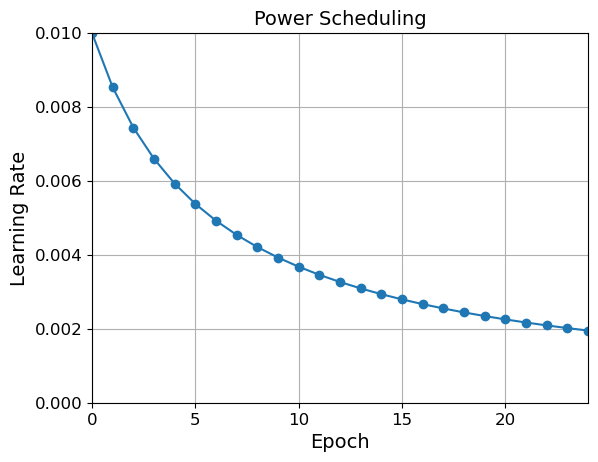

In [78]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

Установите скорость обучения $η_0$ = 0.1 для 5 эпох. Скорость обучения будет постепенно снижаться в 10 раз каждые 5 секунд . В то время как диспетчеризация мощности снижает скорость обучения все медленнее, экспоненциальная диспетчеризация продолжает снижать ее с коэффициентом 10 с шагом. 

```lr = lr0 * 0.1**(epoch / s)```

In [79]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [80]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [81]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [82]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7426 - accuracy: 0.7778 - val_loss: 0.6724 - val_accuracy: 0.8012 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6526 - accuracy: 0.8010 - val_loss: 0.7290 - val_accuracy: 0.8200 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6161 - accuracy: 0.8206 - val_loss: 0.5894 - val_accuracy: 0.8294 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5536 - accuracy: 0.8352 - val_loss: 0.5460 - val_accuracy: 0.8330 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5052 - accuracy: 0.8460 - val_loss: 0.5162 - val_accuracy: 0.8350 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4562 - accuracy: 0.8566 - val_loss: 0.4893 - val_accuracy: 0.8544 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 5s

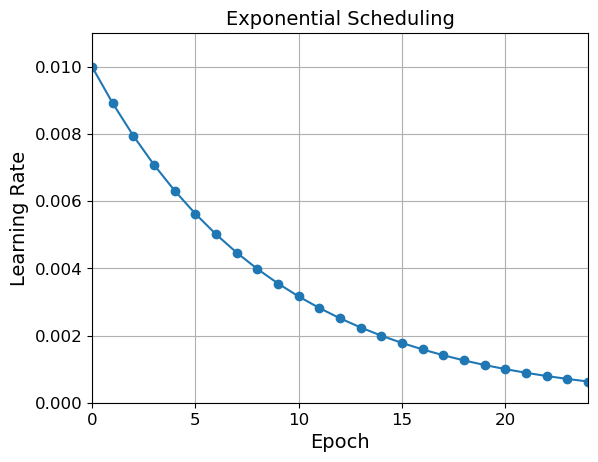

In [83]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [84]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [85]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4687 - accuracy: 0.8361 - val_loss: 0.3612 - val_accuracy: 0.8678 - lr: 8.9124e-04
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3379 - accuracy: 0.8778 - val_loss: 0.3815 - val_accuracy: 0.8676 - lr: 7.9430e-04
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2932 - accuracy: 0.8908 - val_loss: 0.3263 - val_accuracy: 0.8852 - lr: 7.0791e-04
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2592 - accuracy: 0.9030 - val_loss: 0.3252 - val_accuracy: 0.8824 - lr: 6.3092e-04
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2276 - accuracy: 0.9150 - val_loss: 0.3133 - val_accuracy: 0.8908 - lr: 5.6229e-04
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2033 - accuracy: 0.9238 - val_loss: 0.3310 - val_accuracy: 0.8864 - lr: 5.0114e-04
Epoch 7/25
1719/1719 [============

In [86]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

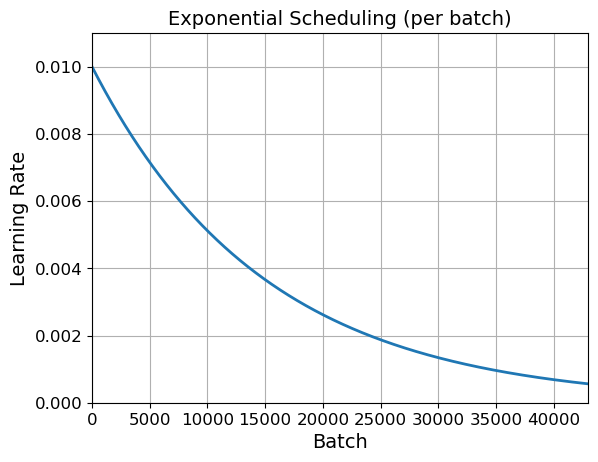

In [87]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

Используйте скорость обучения постоянной в течение ряда эпох (например, $n_0$ = 0,1 в течение 5 эпох), затем меньшая скорость обучения для другого ряда эпох (например, $n_1$ = 0,001 в течение 50 эпох), и так далее. Хотя это решение может работать очень хорошо, оно требует возиться, чтобы выяснить правильную последовательность скоростей обучения и как долго использовать каждый из них.

In [88]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [89]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 3ms/step - loss: 0.7426 - accuracy: 0.7784 - val_loss: 0.7837 - val_accuracy: 0.7962 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6852 - accuracy: 0.7963 - val_loss: 0.7057 - val_accuracy: 0.7968 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7628 - accuracy: 0.7825 - val_loss: 0.8433 - val_accuracy: 0.7630 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8662 - accuracy: 0.7623 - val_loss: 0.9061 - val_accuracy: 0.7308 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9395 - accuracy: 0.7242 - val_loss: 0.8189 - val_accuracy: 0.7224 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5578 - accuracy: 0.8319 - val_loss: 0.6553 - val_accuracy: 0.8366 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

Измеряйте ошибку проверки каждые N шагов (как при ранней остановке) и уменьшайте скорость обучения с коэффициентом λ, когда ошибка перестает падать.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

Наконец, tf.keras предлагает альтернативный способ реализации планирования скорости обучения: определите скорость обучения с помощью одного из расписаний, доступных в keras.optimizers.schedules , а затем передайте эту скорость обучения любому оптимизатору. Этот подход обновляет скорость обучения на каждом этапе, а не в каждой эпохе. Например, здесь показано, как реализовать тот же экспоненциальный график, что и функцию exponential_decay_fn (), которую мы определили ранее:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### Cycle scheduling

В отличие от других подходов, 1 цикл (введенный Лесли Смитом в 2018 paper21) начинается с увеличения начальной скорости обучения η 0 , линейно растущей до η 1 в середине обучения. Затем он уменьшает линейную скорость обучения до η 0 снова во второй половине обучения, завершая последние несколько эпох, снижая скорость на несколько порядков (все еще линейно). Максимальная скорость обучения η 1 выбирается с использованием того же подхода, который мы использовали для нахождения оптимальной скорости обучения, а начальная скорость обучения η 0 выбирается примерно в 10 раз ниже. При использовании импульса мы сначала начинаем с высокого импульса (например, 0,95), затем снижаем его до более низкого импульса в течение первой половины тренировки (например, до 0,85, линейно), а затем возвращаем его к максимальное значение (например, 0,95) во второй половине обучения, заканчивая последние несколько эпох этим максимальным значением. Смит провел много экспериментов, показавших, что этот подход часто позволяет значительно ускорить обучение и достичь лучших результатов. Например, в популярном наборе данных изображений CIFAR10 этот подход достиг точности проверки 91,9% всего за 100 эпох, вместо точности 90,3% в 800 эпохах с помощью стандартного подхода (с той же архитектурой нейронной сети).

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

# Как избежать переобучения через регуляризацию

Глубокие нейронные сети обычно имеют десятки тысяч параметров, иногда даже миллионы. Это дает им невероятную свободу и означает, что они могут вместить огромное количество сложных наборов данных. Но эта большая гибкость также делает сеть склонной к переобучению тренировочного набора. Нам нужна регуляризация.
Мы уже реализовали один из лучших методов регуляризации: ранняя остановка. Более того, хотя пакетная нормализация была разработана для решения проблем с нестабильными градиентами, она также действует как довольно хороший регуляризатор. Далее мы рассмотрим другие популярные методы регуляризации для нейронных сетей: регуляризация ℓ 1 и out 2 , dropout и регуляризация с максимальной нормой.


## $\ell_1$ и $\ell_2$ регуляризация

Ранее для простых линейных моделей, вы можете использовать регуляризацию ℓ 2 для ограничения весов соединений нейронной сети и / или регуляризацию ℓ 1, если вы хотите разреженную модель (со многими весами, равными 0). Вот как применить регуляризацию ℓ 2 к весам соединений слоя Keras, используя коэффициент регуляризации 0,01:

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

Функция l2() возвращает регуляризатор, который будет вызываться на каждом шаге во время обучения для вычисления потери регуляризации. Это затем добавляется к окончательной потере. Как и следовало ожидать, вы можете просто использовать keras.regularizers.l1 (), если вы хотите regular 1 регуляризацию; если вы хотите регуляризацию ℓ 1 и ℓ 2 , используйте keras.regularizers.l1_l2 () (указав оба фактора регуляризации).
Поскольку вы обычно хотите применить один и тот же регуляризатор ко всем слоям в вашей сети, а также использовать одну и ту же функцию активации и одну и ту же стратегию инициализации во всех скрытых слоях, вы можете обнаружить, что повторяете одни и те же аргументы. Это делает код уродливым и подверженным ошибкам. Чтобы избежать этого, вы можете попробовать рефакторинг вашего кода для использования циклов. Другой вариант - использовать функцию Python functools.partial () , которая позволяет создать тонкую оболочку для любого вызываемого объекта с некоторыми значениями аргументов по умолчанию:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

## Dropout

Dropout является одним из самых популярных методов регуляризации для глубоких нейронных сетей. Он был proposed in a paper Джеффри Хинтоном в 2012 году и более подробно описан в 2014 paper Нитиша Шриваставы и др., И он оказался весьма успешным: даже современные нейронные сети получают  повышение точности на 2%, просто добавив Dropout. Это может показаться не так много, но когда модель уже имеет точность 95%, повышение точности на 2% означает снижение частоты ошибок почти на 40% (с 5% ошибки до примерно 3%). 
Это довольно простой алгоритм: на каждом этапе обучения, каждый нейрон ( в том числе входных нейронов, но всегда за исключением выходных нейронов) имеет вероятность р быть временно «обнуление» означает , что он будет полностью игнорироваться при этом шаге обучения, но он может быть активен на следующем шаге (см. Рисунок 11-9  ). Гиперпараметр p называется частотой выпадения , и он обычно устанавливается между 10% и 50%: ближе к 20–30% в повторяющихся нейронных сетях и ближе к 40–50% в сверточных нейронных сетях. После тренировки нейроны больше обнуляются. 

<img src = "dropout.jpg">

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Сначала удивительно, что эта разрушительная техника работает вообще. Будет ли компания работать лучше, если ее сотрудникам будет приказывать бросать монеты каждое утро, чтобы решить, идти на работу или нет? Ну кто знает; возможно это будет! Компания будет вынуждена адаптировать свою организацию; он не мог рассчитывать на то, что какой-либо человек будет работать с кофемашиной или выполнять какие-либо другие важные задачи, поэтому этот опыт придется распространить на несколько человек. Сотрудникам придется учиться сотрудничать со многими из своих сотрудников, а не только с несколькими из них. Компания станет намного более устойчивой. Если один человек уйдет, это не будет иметь большого значения. Неясно, будет ли эта идея работать на самом деле для компаний, но это, безусловно, работает для нейронных сетей. Нейроны, обученные с отсева, не могут совместно адаптироваться с соседними нейронами; они должны быть максимально полезными сами по себе. Они также не могут чрезмерно полагаться только на несколько входных нейронов; они должны обратить внимание на каждый из своих входных нейронов. Они оказываются менее чувствительными к небольшим изменениям во входных данных. В итоге вы получаете более надежную сеть, которая лучше обобщается.
Другой способ понять силу отсева - понять, что на каждом этапе обучения создается уникальная нейронная сеть. Поскольку каждый нейрон может присутствовать или отсутствовать, существует в общей сложности 2 N возможных сетей (где N - общее количество сбрасываемых нейронов). Это настолько большое число, что для одной и той же нейронной сети практически невозможно сделать выборку дважды. После того, как вы выполнили 10 000 этапов обучения, вы, по сути, обучили 10 000 различных нейронных сетей (каждая из которых имеет только один экземпляр обучения). Эти нейронные сети, очевидно, не являются независимыми, потому что они разделяют многие из своих весов, но, тем не менее, все они разные. Результирующая нейронная сеть может рассматриваться как ансамбль усреднения всех этих меньших нейронных сетей.


На практике вы можете обычно применять Dropout только к нейронам в верхнем 1-3 слоях (исключая выходной слой).
Есть одна маленькая, но важная техническая деталь. Предположим, что p = 50%, и в этом случае во время тестирования нейрон будет подключен к вдвое большему количеству входных нейронов, чем было бы (в среднем) во время обучения. Чтобы компенсировать этот факт, нам нужно умножить веса входных соединений каждого нейрона на 0,5 после тренировки. Если мы этого не сделаем, каждый нейрон получит общий входной сигнал примерно в два раза больше, чем то, на котором обучалась сеть, и вряд ли будет работать хорошо. В более общем случае нам нужно умножить вес каждого входного соединения на вероятность удержания (1 - p ) после тренировки. В качестве альтернативы, мы можем разделить выход каждого нейрона на вероятность удержания во время тренировки (эти альтернативы не совсем эквивалентны, но они работают одинаково хорошо). 
Чтобы реализовать Dropout с использованием Keras , вы можете использовать слой `keras.layers.Dropout`. Во время обучения он случайным образом сбрасывает некоторые входные данные (устанавливая их в 0) и делит оставшиеся входные данные на вероятность удержания. После тренировки он вообще ничего не делает; он просто передает входные данные следующему слою. Следующий код применяет регуляризацию отсева перед каждым плотным слоем, используя коэффициент отсева 0,2:

Поскольку dropout активен только во время обучения, сравнение потери при обучении и потери при проверке может вводить в заблуждение. В частности, модель может соответствовать учебному набору и при этом иметь аналогичные потери при обучении и проверке. Поэтому обязательно оцените потерю тренировки без отсева (например, после тренировки).
Если вы заметили, что модель переобучена, вы можете увеличить коэффициент dropout. И наоборот, вы должны попытаться уменьшить коэффициент dropout, если модель не соответствует тренировочному набору. Это также может помочь увеличить частоту выпадения для больших слоев и уменьшить ее для маленьких. Более того, многие современные архитектуры используют dropout только после последнего скрытого слоя, поэтому вы можете попробовать это, если полное выпадение слишком сильное.
Выпадение имеет тенденцию значительно замедлять конвергенцию, но обычно это приводит к гораздо лучшей модели при правильной настройке. Таким образом, это, как правило, стоит дополнительного времени и усилий.
Примечание
Если вы хотите упорядочить самонормализующуюся сеть на основе функции активации SELU (как обсуждалось ранее), вы должны использовать альфа-отсев : это вариант отсева, который сохраняет среднее значение и стандартное отклонение ее входов (он был введен в та же бумага, что и SELU, так как регулярный dropout нарушит самонормализацию).


## Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.evaluate(X_train_scaled, y_train)

In [ ]:
history = model.fit(X_train_scaled, y_train)

## MC Dropout

В 2016 году в статье Ярина Гала и Зубина Гахрамани добавлено еще несколько веских причин для использования отсева:
*	Во-первых, в документе была установлена глубокая связь между сетями dropout (то есть нейронными сетями, содержащими слой dropout перед каждым весовым слоем) и приблизительным байесовским выводом, что дает dropout солидное математическое обоснование.
*	Во-вторых, авторы представили мощную технику, называемую MC Dropout , которая может повысить производительность любой обученной модели dropout без необходимости ее переподготовки или даже вообще ее изменять, обеспечивает гораздо лучший показатель неопределенности модели, а также удивительно прост для воплощать в жизнь.
Если все это звучит как реклама «один странный трюк», взгляните на следующий код. Это полная реализация MC Dropout , улучшающая модель dropout, которую мы обучали ранее, без ее переподготовки:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

Мы просто делаем 100 прогнозов по тестовому набору, устанавливая training = True, чтобы гарантировать, что слой Dropout активен, и собираем прогнозы. Поскольку  Dropout активен, все прогнозы будут разными. Напомним, что predict() возвращает матрицу с одной строкой на экземпляр и одним столбцом на класс Поскольку в тестовом наборе 10 000 экземпляров и 10 классов, это матрица формы [10000, 10]. Мы складываем 100 таких матриц, поэтому y_probas - это массив формы [100, 10000, 10]. Как только мы усредним по первому измерению ( axis = 0 ), мы получим y_proba , массив формы [10000, 10], как мы получили бы с одним прогнозом. Вот и все! Усреднение по нескольким прогнозам с включенным отсевом дает нам оценку по методу Монте-Карло, которая, как правило, более надежна, чем результат одного прогноза с отсечкой. Например, давайте посмотрим на прогноз модели для первого экземпляра в наборе тестов Fashion MNIST, с отключением:

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

Модель кажется почти уверенной, что этот образ относится к 9 классу (лыжный ботинок). Стоит ли доверять этому? Неужели так мало места для сомнений? Сравните это с прогнозами, сделанными при активации отсева:

In [ ]:
np.round(y_probas[:, :1], 2)

Это рассказывает совсем другую историю: по-видимому, когда мы активируем dropout, модель больше не уверена. Кажется, он все еще предпочитает класс 9, но иногда он колеблется с классами 5 (сандали) и 7 (кроссовки), что имеет смысл, учитывая, что все они - обувь. После усреднения по первому измерению мы получаем следующие прогнозы MC Dropout:

In [ ]:
np.round(y_proba[:1], 2)

Модель все еще думает, что это изображение относится к 9 классу, но только с уверенностью 62%, что кажется гораздо более разумным, чем 99%. Кроме того, полезно точно знать, какие другие классы он считает вероятными. И вы также можете взглянуть на standard deviation of the probability estimates:

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

Очевидно, что в оценках вероятности есть довольно много отклонений: если вы строите систему, чувствительную к риску (например, медицинскую или финансовую систему), вам, вероятно, следует относиться к такому неопределенному прогнозу с особой осторожностью. Вы определенно не относитесь к этому как к 99% уверенному прогнозу. Более того, точность модели немного увеличилась с 86,8 до 86,9:

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

Количество используемых образцов Монте-Карло (в данном примере 100) - это гиперпараметр, который вы можете настроить. Чем оно выше, тем точнее будут прогнозы и их оценки неопределенности. Однако, если вы удвоите его, время вывода также будет удвоено. Более того, выше определенного количества образцов вы заметите небольшое улучшение. Таким образом, ваша задача - найти правильный компромисс между задержкой и точностью, в зависимости от вашего приложения.
Если ваша модель содержит другие слои, которые ведут себя особым образом во время обучения (например, слои BatchNormalization ), вам не следует форсировать режим обучения, как мы только что сделали. Вместо этого вы должны заменить слои Dropout следующим классом MCDropout : 


In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Здесь мы просто создаем подкласс Dropout- слоя и переопределяем метод call(), чтобы принудительно установить его training аргумент в True. Кроме того , вы можете определить MCAlphaDropout класс по подклассов AlphaDropout вместо этого. Если вы создаете модель с нуля, это просто вопрос использования MCDropout, а не Dropout . Но если у вас есть модель, которая уже была обучена с использованием Dropout , вам нужно создать новую модель, идентичную существующей модели, за исключением того, что она заменяет слои Dropout на MCDropout , а затем скопируйте веса существующей модели в вашу новую модель.
Короче говоря, MC Dropout - это фантастическая методика, которая улучшает модели dropout и обеспечивает более точные оценки неопределенности. И, конечно же, поскольку это просто регулярное прекращение обучения во время тренировок, оно также действует как регуляризатор.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

## Регуляризация Max-Norm

Другой метод регуляризации, который популярен для нейронных сетей, называется регуляризацией по максимальной норме : для каждого нейрона он ограничивает веса w входящих соединений так, что ∥ w ∥ 2 ≤ r , где r - гиперпараметр максимальной нормы, а ∥ · ∥ 2 является нормой ℓ 2 .  
Макс-норма регуляризации не добавляет термин потери регуляризации к общей функции потерь. Вместо этого он обычно реализуется путем вычисления ∥ w ∥ 2 после каждого шага обучения и при необходимости масштабирования w ( w ← w r / / w ‖ 2 ). 
Снижение r увеличивает степень регуляризации и помогает уменьшить переобучение. Регуляризация макс-нормы также может помочь решить проблемы нестабильных градиентов (если вы не используете пакетную нормализацию).
Чтобы реализовать регуляризацию max-norm в Keras, установите для аргумента kernel_constraint каждого скрытого слоя ограничение max_norm() с соответствующим значением max, например:
```python
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                   kernel_constraint=keras.constraints.max_norm(1.))
```
После каждой обучающей итерации метод fit() модели будет вызывать объект, возвращаемый max_norm(), передавая ему веса слоя и получая взамен измененные веса, которые затем заменяют веса слоя. Как вы увидите плзднее, вы можете при необходимости определить свою собственную функцию ограничения и использовать ее как `kernel_constraint`. Вы также можете ограничить условия смещения, установив аргумент `bias_constraint`.
Функция max_norm() имеет аргумент оси, который по умолчанию равен 0 . Плотный слой обычно имеет вес формы [number of inputs, number of neurons], поэтому использование axis = 0 означает , что максимальное ограничение-норма будет применяться независимо друг от друга , чтобы вектор весовых коэффициентов каждого нейрона. Если вы хотите использовать max-norm со сверточными слоями, убедитесь, что вы правильно установили аргумент оси ограничения max_norm() (обычно axis = [0, 1, 2] ).

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))